# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [111]:
from sklearn.datasets import load_boston
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor  
#from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import tree
import pylab as pl 
import numpy as np
import itertools
import matplotlib.pyplot as pylab
#from matplotlib.colors import ListedColormap

In [123]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [84]:
#a
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

def s(X, y, base_algorithms_list, coefficients_list):
    return - (gbm_predict(X, base_algorithms_list, coefficients_list) - y)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [89]:

X = boston_data['data']
y = boston_data['target']
last_element = int(len(X) * .25)
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.25)
train_data = X[:-last_element]
test_data = X[-last_element:]
train_labels = y[:-last_element]
test_labels = y[-last_element:]
print train_data[0]


[  6.32000000e-03   1.80000000e+01   2.31000000e+00   0.00000000e+00
   5.38000000e-01   6.57500000e+00   6.52000000e+01   4.09000000e+00
   1.00000000e+00   2.96000000e+02   1.53000000e+01   3.96900000e+02
   4.98000000e+00]


In [95]:
def busting(X,y,N,s_init, base_algorithms_list, coefficients_list):
    for i in range(N-1):
        print i
        print s_init[0]
        new_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
        new_tree.fit(X,s_init)
        base_algorithms_list.append(new_tree) 
        coefficients_list.append(0.9 / (1.0 + i))
        s_init = s(X, y, base_algorithms_list, coefficients_list)
    return base_algorithms_list, coefficients_list
def write_answer(ans):
    with open('answer.txt', 'w') as f_out:
        f_out.write(str(np.round(ans)))

In [96]:
b_init = DecisionTreeRegressor(max_depth=5, random_state=42)
b_init.fit(train_data, train_labels)
base_algorithms_list = [b_init]
coefficients_list = [0.9]
s_init = s(train_data, train_labels, base_algorithms_list, coefficients_list)
N = 50
base_algorithms_list, coefficients_list = busting(train_data, train_labels, N, s_init, base_algorithms_list, coefficients_list)

0
-0.102
1
-0.0102
2
-0.326012929941
3
-0.537956078789
4
-0.483369008456
5
-0.335430022699
6
-0.368072987698
7
-0.226410147454
8
-0.163077965661
9
-0.171586779438
10
-0.18046203796
11
-0.152467663351
12
-0.172445536166
13
-0.105414305938
14
-0.108589511009
15
-0.0791597196762
16
-0.0343762373026
17
-0.0367593773695
18
-0.048951244275
19
-0.0537686821168
20
-0.0233840342915
21
-0.0245954274849
22
-0.010742213043
23
0.0143527679921
24
0.0216059800739
25
0.0243041875389
26
0.0209463981465
27
0.0229951135801
28
0.0239126230279
29
0.0365596177619
30
0.0339441816625
31
0.032392435515
32
0.0435199340294
33
0.0381224250447
34
0.0431028505692
35
0.04340165182
36
0.0427295975749
37
0.0423058181708
38
0.0340029295686
39
0.0346714849708
40
0.0343061072773
41
0.0375279414905
42
0.030313800932
43
0.0341230540872
44
0.0274146738449
45
0.0287527659124
46
0.0275175780903
47
0.0153402990166
48
0.0158651828571


In [97]:
mse = mean_squared_error(test_labels, gbm_predict(test_data, base_algorithms_list, coefficients_list))
rmse = mse ** .5
print("mse = %d, rmse = %d" % (mse, rmse))

mse = 26, rmse = 5


In [93]:
len( base_algorithms_list)

50

In [94]:
write_answer(rmse)

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 9). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [106]:
estimator = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators= 5)
estimator.fit(train_data, train_labels)
estimator.score(test_data, test_labels)
#score = cross_validation.cross_val_score(estimator, train_data, train_labels, scoring = 'accuracy', cv = 3)   


-1.3667661356744474

In [125]:
scoring = []
n_trees = [1] + range(10, 55, 5) 
for n_tree in n_trees:
    estimator = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, n_estimators= n_tree)
    estimator.fit(train_data, train_labels)
    score = estimator.score(test_data, test_labels)    
    scoring.append(score)
#scoring = np.asmatrix(scoring)



In [126]:
print scoring
print n_trees

[-3.0097945875545431, -0.92898853186299057, -0.42441195977125834, -0.29033992082575444, -0.24145285330032373, -0.32843858981615903, -0.25296826908535985, -0.12981110495106662, -0.088459094367528968, -0.18848385707765347]
[1, 10, 15, 20, 25, 30, 35, 40, 45, 50]


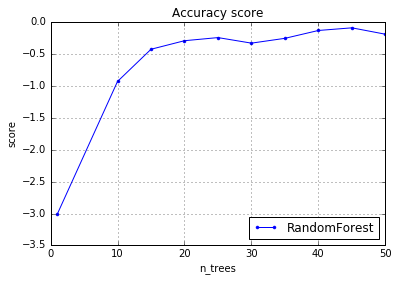

In [127]:
pylab.plot(n_trees, scoring, marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')


## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.